<a href="https://colab.research.google.com/github/kassio077/Aprendizado-de-maquina/blob/master/Atividade_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de regressão

O Dataset consiste em informações de um ambiente simulado de ataques a uma LAN (Network de Área Local) Militar. A base de dados é composta por 42 atributos e 25192 instâncias que estão classificadas como:

1.  anormaly
2.   normal

Os atributos descrevem se uma conexão representa ou não um ataque de intruso a rede.

# 1.Carregando os dados

In [24]:
from google.colab import drive

import numpy as np
import pandas as pd

dados = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/dados_lan2.csv')
data_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Test_data.csv')

#2.Bibliotecas

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import RandomizedSearchCV



# Limpeza e organização dos dados

In [26]:
#Remoção dos atributos
dados = dados.drop(columns=['service','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins',
                            'num_compromised','root_shell','su_attempted','num_root',
                            'num_file_creations','num_shells','num_access_files',
                            'num_outbound_cmds','is_host_login','is_guest_login'])


In [ ]:
dados.head()

,duration,protocol_type,flag,logged_in,count_,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,classe
0,0,tcp,SF,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,SF,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,S0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,SF,1,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,SF,1,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# 3. Análise preliminar dos dados 

Para encontrar a função que melhor mapeie os valores de entrada, analisamos o atributo a ser previsto com alguns que farão parte da construção da função, e assim, encontrar uma melhor aproximação dos valores. 

> **Análisando o atributo a ser estimado**



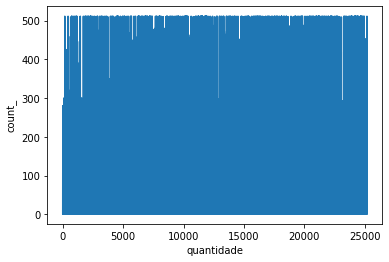

In [27]:
plt.plot(dados.count_)
plt.xlabel('quantidade')
plt.ylabel('count_')
plt.show()

* Correlação com atributo alvo

Podemos vizualizar que a uma correlação do atributo alvo da regresão **count_** com o atributo **srv_count**. Quando o contador cresce o outro também cresce, cerca de 50% das instâncias tem esta caracteristica. Isso é quer dizer que este atributo contribuirá para o modelo da função.

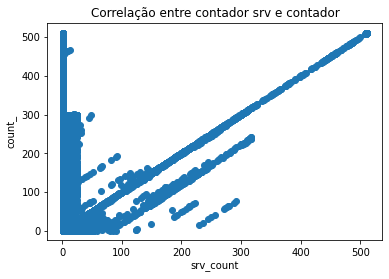

In [ ]:
plt.scatter(dados.srv_count, dados.count_)
plt.xlabel('srv_count')
plt.ylabel('count_')
plt.title('Correlação entre contador srv e contador')
plt.show()

In [ ]:
corr = dados.count_.corr(dados.srv_count)
corr

0.46972750058724355

Para os atributos serror_rate e rerror_rate existe uma correlação negativa em uma parte das instâncias. Quando a taxa de erro começa a diminuir para ambas.

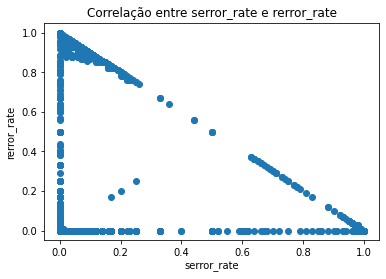

In [ ]:
plt.scatter(dados.serror_rate, dados.rerror_rate)
plt.xlabel('serror_rate')
plt.ylabel('rerror_rate')
plt.title('Correlação entre serror_rate e rerror_rate')
plt.show()

In [ ]:
corr = dados.serror_rate.corr(dados.rerror_rate)
corr

-0.22752171317930314

* Frequência média do contador

Existe uma media maior entre as instâncias de tipo de protocolo tcp em relação as outros. Como podemos visualizar no gráfico.   

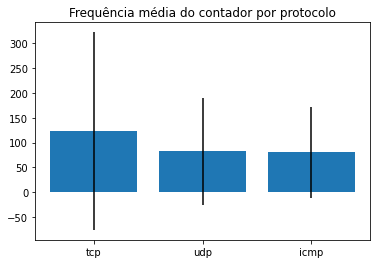

In [ ]:
indice = ['tcp','udp','icmp']
stats = dados.groupby(['protocol_type'],as_index=False)['count_'].agg(['mean','std'])
plt.bar(indice,stats['mean'],yerr=stats['std'])
plt.title('Frequência média do contador por protocolo')
plt.show()

> **Relação entre atributo discreto (classe) com atributo (protocol_type) e atributo alvo da regresão (count_).**

* Separando o dataset

In [ ]:
#Dataframe apenas para as conexões normais
normal = dados[dados['classe']=='normal']

#Dataframe apenas para as conexões anomaly
anomaly = dados[dados['classe']=='anomaly']


* Ocorrências do tipo de protocolo nas conexões normais.

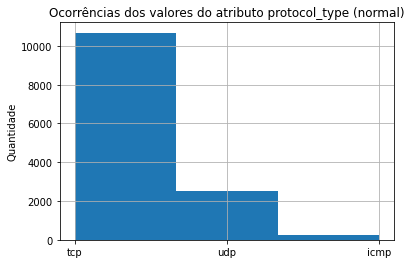

In [ ]:
plt.hist(normal['protocol_type'],3)
plt.ylabel('Quantidade')
plt.title('Ocorrências dos valores do atributo protocol_type (normal)')
plt.grid(True)
plt.show()

* Ocorrências do tipo de protocolo nas conexões anomaly.

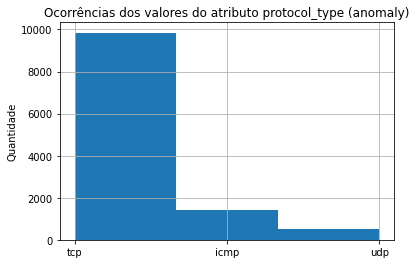

In [ ]:
plt.hist(anomaly['protocol_type'],3)
plt.ylabel('Quantidade')
plt.title('Ocorrências dos valores do atributo protocol_type (anomaly)')
plt.grid(True)
plt.show()

> **Comparando as ocorrências do valor do contador nas conexões normais e anomaly.**

  Podemos observar no histograma, que os valores estão mais dispersos nas conexões anormais, e constantes nas conexões normais.

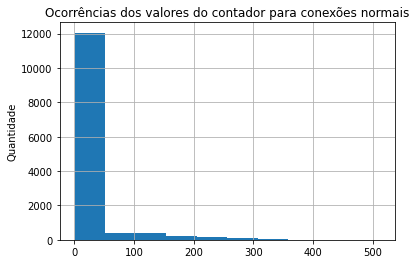

In [ ]:
plt.hist(normal['count_'])
plt.ylabel('Quantidade')
plt.title('Ocorrências dos valores do contador para conexões normais')
plt.grid(True)
plt.show()

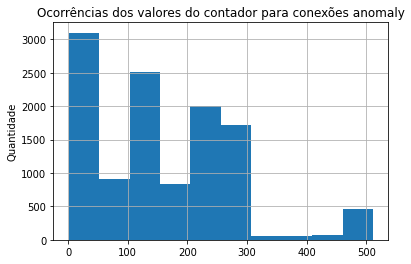

In [ ]:
plt.hist(anomaly['count_'])
plt.ylabel('Quantidade')
plt.title('Ocorrências dos valores do contador para conexões anomaly')
plt.grid(True)
plt.show()

Com o gráfico de distribuição de probabilidade, visualizamos melhor esta diferença para as duas classes de forma continua. Isso mostra que as conexões anormais não segue um padrão.

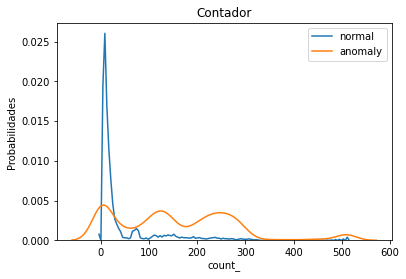

In [ ]:
# distribuição de probabilidade comparando o contador para as duas classes
sns.distplot(normal.count_, hist=False, rug=False,label='normal')
sns.distplot(anomaly.count_, hist=False, rug=False,label='anomaly')
plt.xlabel('count_')
plt.ylabel('Probabilidades')
plt.title('Contador')
plt.show()

* Correlação entre atributos

In [ ]:
#calculando correlação dos dados
corr = dados.corr()

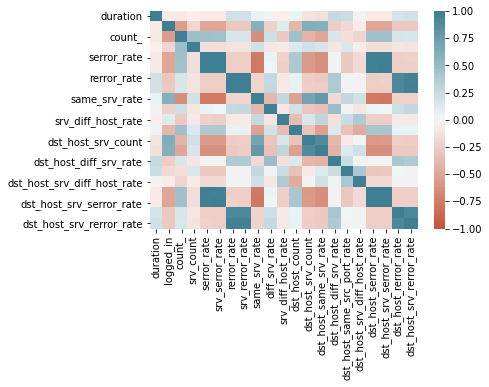

In [ ]:
#plotando coeficientes de correlação em um mapa de calor
sns.heatmap(corr,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

#4. Adequando os dados para o modelo
 **Transformação dos dados**

In [6]:
#Transformando atributos categoricos em numéricos.

dados['classe'] = dados['classe'].replace(['anomaly','normal'],[1,0])

dados['protocol_type'] = dados['protocol_type'].replace(['tcp','udp','icmp'],[1,2,3])

label_encoder = preprocessing.LabelEncoder()
dados['flag'] = label_encoder.fit_transform(dados['flag'])

dados.head()

,duration,protocol_type,flag,logged_in,count_,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,classe
0,0,1,9,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,2,9,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,1,5,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,1,9,1,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,1,9,1,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  int64  
 2   flag                         25192 non-null  int64  
 3   logged_in                    25192 non-null  int64  
 4   count_                       25192 non-null  int64  
 5   srv_count                    25192 non-null  int64  
 6   serror_rate                  25192 non-null  float64
 7   srv_serror_rate              25192 non-null  float64
 8   rerror_rate                  25192 non-null  float64
 9   srv_rerror_rate              25192 non-null  float64
 10  same_srv_rate                25192 non-null  float64
 11  diff_srv_rate                25192 non-null  float64
 12  srv_diff_host_rate           25192 non-null  float64
 13  dst_host_count  

**Re-escala dos dados**

In [7]:
dados = (dados - dados.min())/(dados.max()-dados.min())
dados.head()


,duration,protocol_type,flag,logged_in,count_,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,classe
0,0.0,0.0,0.9,0.0,0.001961,0.001961,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0
1,0.0,0.5,0.9,0.0,0.023529,0.000000,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0
2,0.0,0.0,0.5,0.0,0.239216,0.009804,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1.0
3,0.0,0.0,0.9,1.0,0.007843,0.007843,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0
4,0.0,0.0,0.9,1.0,0.056863,0.060784,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


#5. Preparando o modelo
**Dividindo os dados**

Dividimos os dados descritores (X) do atributo alvo da regressão **count_**  (y).

In [8]:
#dividindo dados em atributos descritores e atributo alvo
X = dados.drop(columns=['count_'])
X.head()

,duration,protocol_type,flag,logged_in,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,classe
0,0.0,0.0,0.9,0.0,0.001961,0.0,0.0,0.0,0.0,1.00,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0.0
1,0.0,0.5,0.9,0.0,0.000000,0.0,0.0,0.0,0.0,0.08,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0.0
2,0.0,0.0,0.5,0.0,0.009804,1.0,1.0,0.0,0.0,0.05,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1.0
3,0.0,0.0,0.9,1.0,0.007843,0.2,0.2,0.0,0.0,1.00,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0.0
4,0.0,0.0,0.9,1.0,0.060784,0.0,0.0,0.0,0.0,1.00,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


In [9]:

y = dados.count_
y.head()

0    0.001961
1    0.023529
2    0.239216
3    0.007843
4    0.056863
Name: count_, dtype: float64

In [10]:
#Definindo os dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)#random_state=42

**Treinando os modelos e fazendo previsão**


**1. Comparando resultados**

Podemos visualizar nos gráficos os valores reais do contador em azul, comparados aos previstos pela função aproximada em laranja das instâncias de teste.

Comparado aos outros o modelo da random forest apresentou uma função mais aproximada dos dados reais. 



* Regressão linear 

In [14]:
#definindo modelo de regressão linear
linear = LinearRegression()
linear.fit(X_train,y_train)
#predição dos valores
pred_linear = linear.predict(X_test)

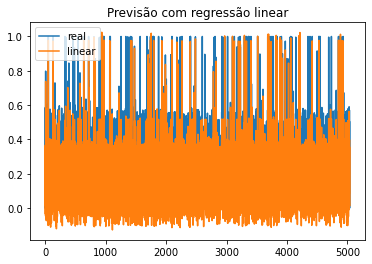

In [ ]:
#plotando resultados da regressão linear
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_linear,label='linear')
plt.legend()
plt.title('Previsão com regressão linear')
plt.show()

* Árvore de decisão

In [17]:
#definindo modelo de árvore de decisão
arvore = DecisionTreeRegressor()
arvore.fit(X_train,y_train)
pred_arvore = arvore.predict(X_test)

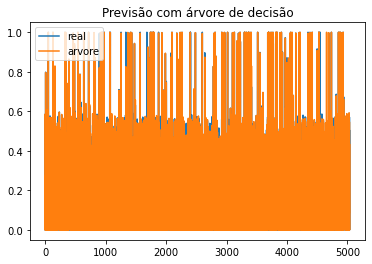

In [ ]:
#plotando resultados da árvore de decisão
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_arvore,label='arvore')
plt.legend()
plt.title('Previsão com árvore de decisão')
plt.show()

In [ ]:
for i in range(len(y_test)-4900):
  print(y_test.iloc[i],'\t',pred_arvore[i])

* Radom forest

In [18]:
#definindo modelo de random forest
floresta = RandomForestRegressor(n_estimators=100)
floresta.fit(X_train,y_train)
pred_floresta = floresta.predict(X_test)

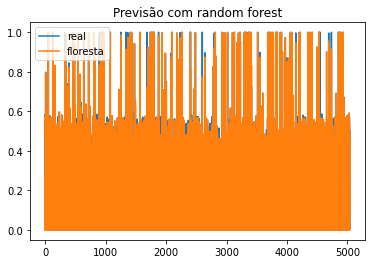

In [ ]:
#plotando resultados da random forest
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_floresta,label='floresta')
plt.legend()
plt.title('Previsão com random forest')
plt.show()

* MLP

In [19]:
#define modelo MLP
mlp = MLPRegressor(hidden_layer_sizes=(200,50),activation='logistic',max_iter=1000)
mlp.fit(X_train,y_train)
pred_mlp = mlp.predict(X_test)

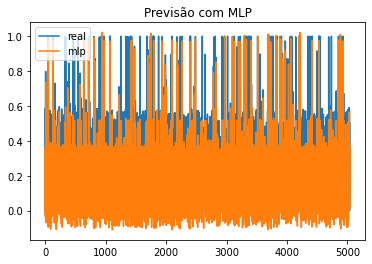

In [ ]:
#plotando resultados da MLP
plt.plot(y_test.reset_index(drop=True),label='real')
plt.plot(pred_mlp,label='mlp')
plt.legend()
plt.title('Previsão com MLP')
plt.show()

**2. Avaliando os resultados**

De forma númerica, assim como na forma visual dos gráficos, a Radom Forest teve melhores resultados, quando aplicamos métricas que apresentam resultados desta forma aos dados de teste, comparados aos previstos pelos modelos esta tendência também se repetiu.

Como os dados a serem previsto pela função são reais as métricas usadas foram Mean Absolute Error (MAE) e Root Mean Squared Error (RMSE). Logo, quanto menor for o erro melhor avaliado será o modelo.

* Mean Absolute Error (MAE)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
#Mae Regressão linear
mean_absolute_error(y_test,pred_linear)

0.06914706217967682

In [ ]:
#Mae Árvore
mean_absolute_error(y_test,pred_arvore)

0.009476734915619974

In [ ]:
#Mae Radom Forest
mean_absolute_error(y_test,pred_floresta)

0.009029969027498298

In [23]:
mean_absolute_error(y_test,pred_mlp)

0.0686955190070879

* Root Mean Squared Error (RMSE)

In [12]:
from sklearn.metrics import mean_squared_error

In [15]:
#RMSE Regressão 
mean_squared_error(y_test,pred_linear)**(1/2)

0.099310635477679

In [20]:
#RMSE Arvore de decisão
mean_squared_error(y_test,pred_arvore)**(1/2)

0.027286963406662576

In [21]:
#RMSE Radom Forest
mean_squared_error(y_test,pred_floresta)**(1/2)

0.022806946340907307

In [22]:
#RMSE MLP
mean_squared_error(y_test,pred_mlp)**(1/2)

0.09761289373791154

**3. Otimizando parâmetros**

> **MLP com Random search** (modelo 1)

In [ ]:
#Espaço de busca
param_grid = [
              {
                  'hidden_layer_sizes': [(10),(50),(80),(50,5),(90,50)],
                  'activation': ['identity', 'logistic', 'tanh', 'relu'],
                  'solver': ['lbfgs', 'sgd', 'adam'],
                  'max_iter': [500,900,1800]
              }
              
]

In [ ]:
from sklearn.metrics import mean_absolute_error
#Definindo o modelo 
mlp = RandomizedSearchCV(MLPRegressor(),param_grid,cv=5,error_score='mean_absolute_error')

In [ ]:
mlp.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

RandomizedSearchCV(cv=5, error_score='mean_absolute_error',
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_fun=15000, max_iter=200,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, p...
                                          verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'activation': ['identity', 'logistic',
               

Avaliação com Mean Absolute Error:

In [ ]:
#Melhor configuração sorteada
print(mlp.best_params_)

{'solver': 'lbfgs', 'max_iter': 900, 'hidden_layer_sizes': 50, 'activation': 'relu'}


In [ ]:
print(round(mlp.best_score_,3))

0.97


---
> **MLP com Random search** (modelo 2)

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mlp = RandomizedSearchCV(MLPRegressor(),param_grid,cv=5,error_score='mean_squared_error')

In [ ]:
mlp.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

RandomizedSearchCV(cv=5, error_score='mean_squared_error',
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_fun=15000, max_iter=200,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, po...
                                          verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions=[{'activation': ['identity', 'logistic',
               

Avaliação com Mean Squared Error:

In [ ]:
#Melhor configuração sorteada
print(mlp.best_params_)

{'solver': 'lbfgs', 'max_iter': 500, 'hidden_layer_sizes': 80, 'activation': 'relu'}


In [ ]:
print(round(mlp.best_score_,3))

0.969


---
> **MLP com Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
mlp = GridSearchCV(MLPRegressor(),param_grid,cv=5,error_score='mean_absolute_error')

In [ ]:
mlp.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

GridSearchCV(cv=5, error_score='mean_absolute_error',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_fun=15000,
                                    max_iter=200, momentum=0.9,
                                    n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t...
                                    solver='adam', tol=0.0001,
                                    validation_fraction=0.1, verbose=False,
                                    warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                 

Avaliação com Mean Absolute Error:

In [ ]:
#Melhor combinação do espaço de busca
print(mlp.best_params_)

{'activation': 'relu', 'hidden_layer_sizes': (90, 50), 'max_iter': 1800, 'solver': 'lbfgs'}


In [ ]:
print(round(mlp.best_score_,3))

0.975


---


> **Avaliando MLP Grid Search**

A partir da geração da melhor configuração do espaço de busca utilizando o grid search, aplicamos a métrica MSE com validação cruzada para avaliar o modelo.

* Mean Squared Error (MSE)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
#MLP com a melhor configuração
mlp = MLPRegressor(hidden_layer_sizes=(90,50),activation='relu',max_iter=1800, solver='lbfgs')

In [ ]:
#calculando os scores
scores = cross_val_score(mlp,X,y,cv=5,error_score='mean_squared_error')
scores

array([0.97545173, 0.97529689, 0.9756993 , 0.97432557, 0.97770341])

In [ ]:
round(scores.mean(),3),round(scores.std(),3)

(0.976, 0.001)